In [1]:
# Importing libraries for data manipulation
import sqlite3
import pandas as pd

# Importing libraries for data visualization
import matplotlib.pyplot as plt

# Importing libraries for data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Importing libraries for classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report

# Importing libraries for classification models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier


from py_helpers.pipeline_helper import *
from py_helpers.db_helper import *



In [2]:
"""
Define the list of attributes and table names
Example of how to fetch data from multiple tables
attributes = ["t1.attribute1", "t2.attribute2", "t3.attribute3", "t4.attribute4"] # Any attribute names that we want to fetch
table_names = ["table1", "table2", "table3", "table4"]  # The table names that we want to join
join_conditions = ["t1.id = t2.id", "t1.id = t3.id", "t1.id = t4.id"]  # The join conditions for the tables
"""
"""
# Fetching data from the database
attributes = ["t1.year", "t1.playoff"] # Any attribute names that we want to fetch
table_names = ["teams"]  # The table names that we want to join
join_conditions = []  # The join conditions for the tables

# Removing the table names from attributes
cleaned_attributes = [attr.split('.')[1] for attr in attributes]
"""

'\n# Fetching data from the database\nattributes = ["t1.year", "t1.playoff"] # Any attribute names that we want to fetch\ntable_names = ["teams"]  # The table names that we want to join\njoin_conditions = []  # The join conditions for the tables\n\n# Removing the table names from attributes\ncleaned_attributes = [attr.split(\'.\')[1] for attr in attributes]\n'

In [3]:
df = retrieve_data('./db/WNBA_cleared.db', 'merged')
df = df.drop(['tmID'], axis=1)
df.drop(['rank'], axis=1, inplace=True) # to good be true

# Shuffling the DataFrame
df = df.sample(frac=1, random_state=42) 

In [4]:
# Metrics to be used for evaluation of the model performance
metrics =  {
    'accuracy' : accuracy_score,    # Accuracy -> bad with unbalanced data
    'precision' : precision_score,  # Precision -> good with unbalanced data (high precision means low false positives)
    'recall' : recall_score,        # Recall -> good with unbalanced data (high recall means low false negatives)
    'f1' : f1_score,                # F1 -> good with unbalanced data (high f1 means low false positives and false negatives)
    'roc_auc' : roc_auc_score       # ROC AUC -> good with unbalanced data (high roc auc means low false positives and false negatives)
}

In [5]:
target = 'playoff'  # The target attribute
seed = 42           # The random seed for the train-test split

In [6]:
# Define the pipeline with different models

# Logistic Regression Pipeline Model (model_lr)
model_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=seed))
])

# Random Forest Pipeline Model (model_rf)
model_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=seed))
])

# Support Vector Machine Pipeline Model (model_svm)
model_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(random_state=seed))
])

# Gradient Boosting Machine Pipeline Model (model_gb)
model_gb = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', GradientBoostingClassifier(random_state=seed))
])

# Neural Network Pipeline Model (model_nn)
model_nn = Pipeline([
    #('scaler', StandardScaler()),
    ('classifier', MLPClassifier(random_state=seed))
])

# Dictionary of all the models
all_models =  { 'Logistic Regression' : model_lr, 
                'Random Forest' : model_rf, 
                'Support Vector Machine' : model_svm, 
                'Gradient Boosting' : model_gb, 
                'Neural Network' : model_nn
              }

In [7]:
all_results = { 'sliding': [], 'expanding': [] , 'mixed' : []}

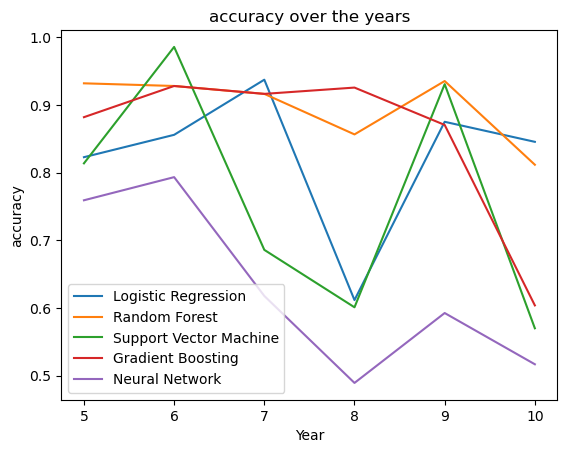

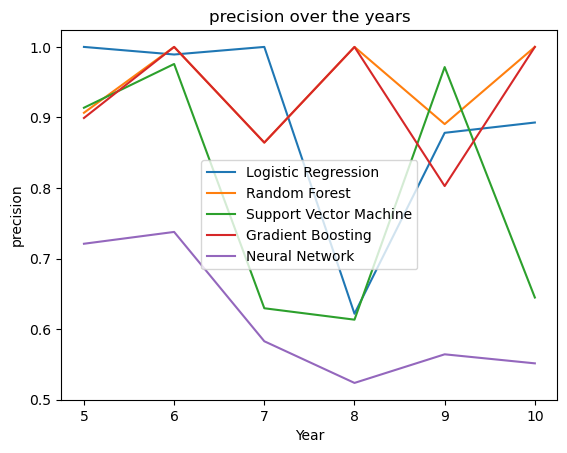

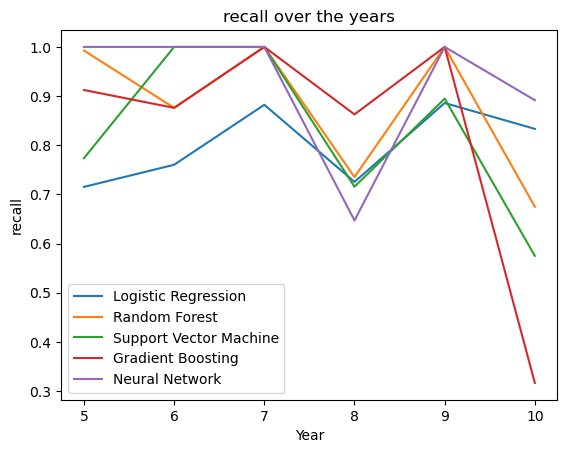

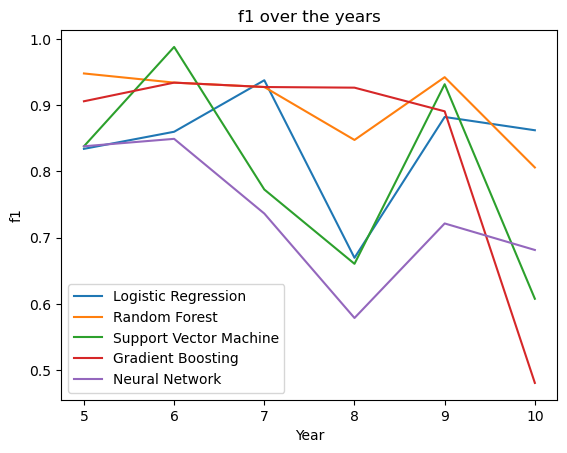

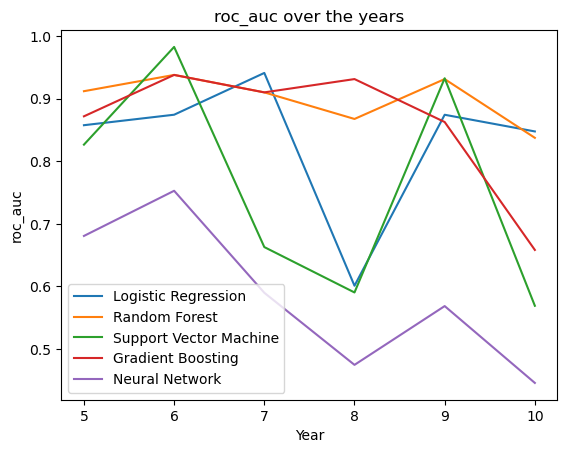

In [8]:
# Sliding window analysis
total_years = 10 # Total number of years that we have data for
window_size = 4 # Maybe test with different window sizes

start = 5

all_results['sliding'] = {}
for model_name, model in all_models.items():
    all_results['sliding'][model_name] = sliding_window_analysis(df, start, total_years, window_size, target, metrics, model)

plot_metrics_for_models(all_results['sliding'], all_models, start, total_years, metrics)

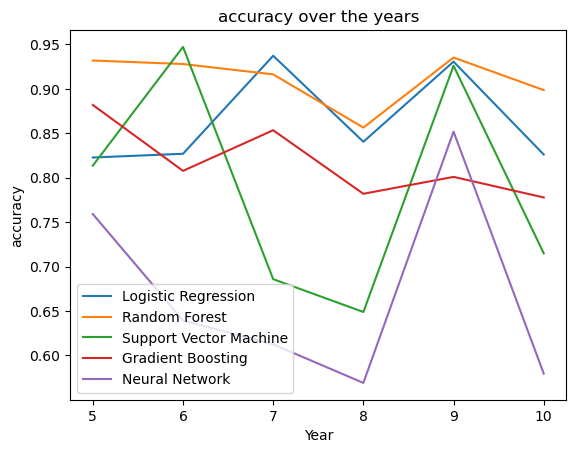

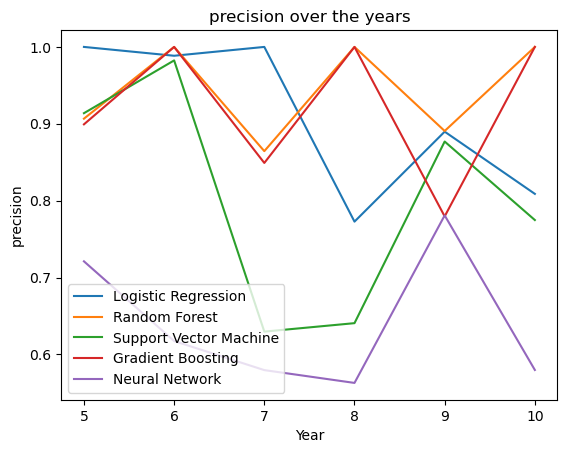

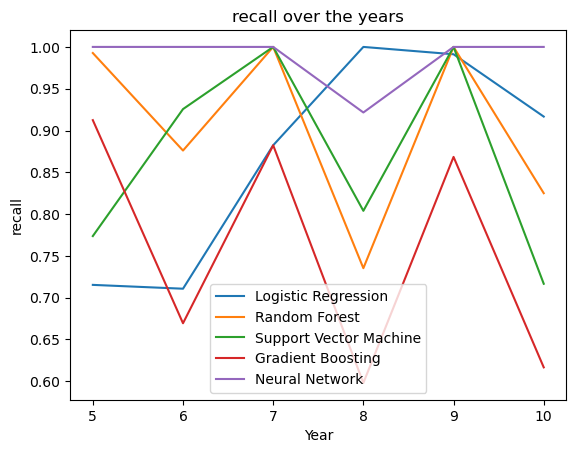

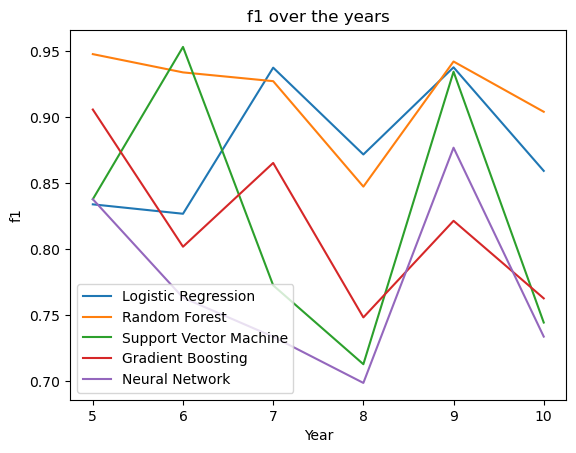

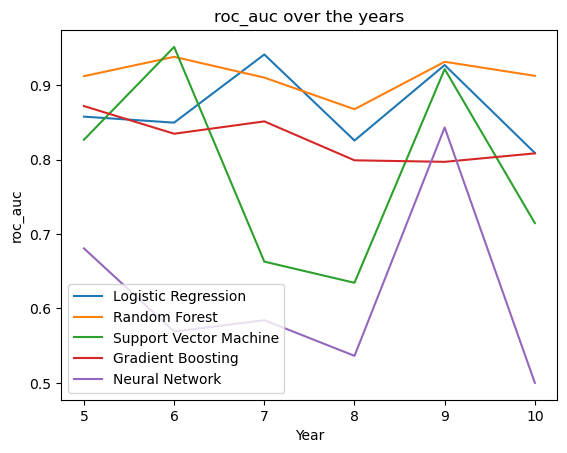

In [9]:
# Expanding window analysis
total_years = 10  # Total number of years that we have data for
start = 5 # Should be higher than 1 because we need to have at least 1 year of training data

all_results['expanding'] = {}
for model_name, model in all_models.items():
    all_results['expanding'][model_name] = expanding_window_analysis(df, start, total_years, target, metrics, model)

plot_metrics_for_models(all_results['expanding'], all_models, start, total_years, metrics)

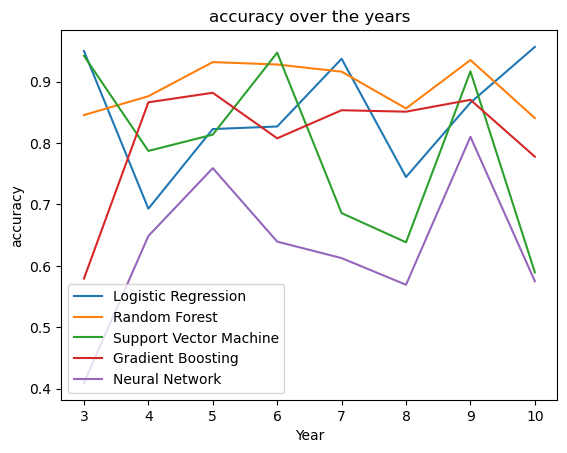

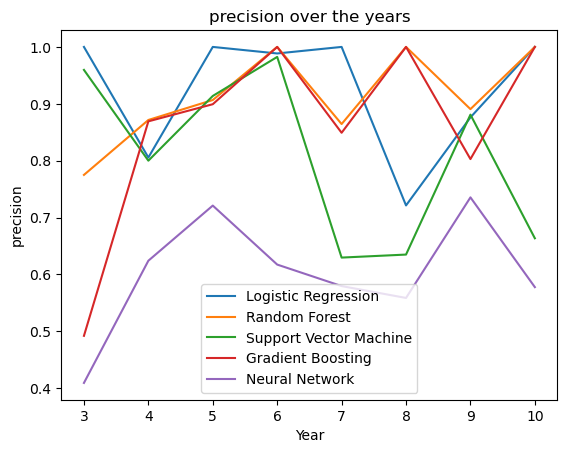

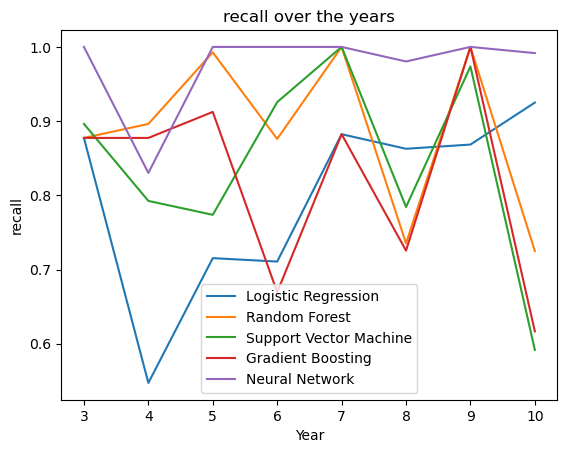

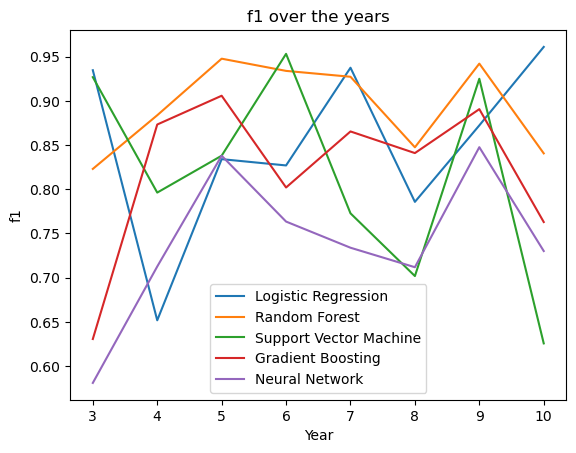

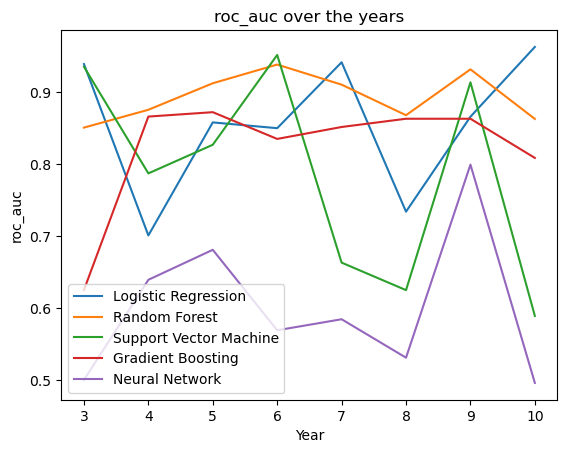

In [10]:
# Mixed window analysis
total_years = 10  # Total number of years that we have data for
start = 3  # Should be higher than 1 because we need to have at least 1 year of training data
start_sliding = 6  # Decide when to start sliding when predicting the 6th year

all_results['mixed'] = {}
for model_name, model in all_models.items():
    all_results['mixed'][model_name] = mixed_window_analysis(df, total_years, start, start_sliding, metrics, model, target)

plot_metrics_for_models(all_results['mixed'], all_models, start, total_years, metrics)

In [11]:
# # Hyperparameter tuning example
# # Example for RandomForestClassifier
# from sklearn.model_selection import GridSearchCV
# param_grid = {
#     'classifier__n_estimators': [100, 200, 300],
#     'classifier__max_depth': [None, 5, 10, 20],
#     'classifier__min_samples_split': [2, 5, 10]
# }
# grid_search = GridSearchCV(pipeline, param_grid, cv=5)
# grid_search.fit(x, y)
# print("Best parameters:", grid_search.best_params_)
# 
# # Cross-validation example
# from sklearn.model_selection import cross_val_score
# scores = cross_val_score(pipeline, x, y, cv=5)
# print("Cross-validation scores:", scores)
# 
# # Testing the model on new data
# # Example using df_sixth_year as new data
# x_test = df_sixth_year.drop(columns=[target])
# y_test = df_sixth_year[target]
# y_pred_test = pipeline.predict(x_test)
# accuracy_test = accuracy_score(y_test, y_pred_test)
# print(f"Test Accuracy: {accuracy_test}")
# 